In [143]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

### 1. Read data CSV and split into train and test sets

In [144]:
path = f"{os.getcwd()}/data/training-data.csv"
data = pd.read_csv(path, on_bad_lines="skip", delimiter=';')

### 2 Preprocess Data

In [145]:
# Fetch stopwords vocabulary
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

def preprocess_text(text):
  # Typecasts non string values into strings
  if not isinstance(text, str):
    text = str(text)

  # Converts text to lower case
  text = text.lower()

  # Remove special characters
  r"""
  Removes any characters that is NOT:
  \w -> word characters (letters, digit, underscore)
  \s -> whitespace characters (spaces, tabs, newlines)
  """
  text = re.sub(r'[^\w\s]', '', text)

  # Tokenize string
  tokens = word_tokenize(text)

  # Remove stop words (words with low information value) e.g. "a", "I", "an", "but", etc...
  stopwords_set = set(stopwords.words("english"))
  tokens = [word for word in tokens if word not in stopwords_set] # Only add words that are not in the stop_wrods list

  # Apply porter stemmer algorithm to simplify vocabulary
  tokens = [PorterStemmer().stem(word) for word in tokens]

  return ' '.join(tokens)

data['text'] = data['text'].apply(preprocess_text)


### 3. Split Train, Test, Validate

In [146]:
# First Split: sepereate out test data (90% train + validation, 10% test)
train_validation_data, test_data = train_test_split(
  data,
  train_size=0.8,
  test_size=0.2,
  random_state=42
)

# Second Split: seperate out train 70% and 20% validation
train_data, validation_data = train_test_split(
  train_validation_data,
  train_size=0.7,
  test_size=0.2,
  random_state=42
)

### 4. Calculate initial probability for each label

In [147]:
labels = train_data.label
total_data_frequency = len(labels)
label_frequencies = labels.value_counts().to_numpy()
initial_probability = np.array([frequency / total_data_frequency for frequency in label_frequencies])

### 5. Count how many times word X appears in label 0, 1, 2

In [148]:
token_freq_map = {}
token_freq_per_label = [0, 0 ,0]
for i, row in train_data.iterrows():
  label = row.label
  tokens = str(row.text).split()

  # Add the tokens count for the label
  token_freq_per_label[label] += len(tokens)

  for token in tokens:
    # label 0, 1, 2 is labeled by the array's index, whilst the element is the count. e.g. map["I"][0] -> how many times token "I" appear  in label 0
    if token not in token_freq_map:
      # Initialize empty list for non existing tokens
      token_freq_map[token] = [0, 0, 0]

    token_freq_map[token][label] += 1


### 6. Create a test function that tests probability results

In [149]:
# Used to test the given text against the calculated probabilities (this is declared on top because it needs to be used to find the best smoothing value)
def classify(text, token_probabilities):
  scores = initial_probability.copy()
  tokens = text.split()

  # Calculate probability for each label
  for label in range(len(scores)):
    for token in tokens:
      if token in token_probabilities:
        scores[label] *= token_probabilities[token][label]

  # Retrieve the largest guess score's index (AKA. the label)
  predicted_label = np.argmax(scores)
  return predicted_label

### 7. Calculate the probability of word X in label 0, 1, 2

In [150]:
def calculate_probability(smoothing):
  token_probabilities = {}
  token_length = len(token_freq_map)

  for token, occurences in token_freq_map.items():
    token_probabilities[token] = []
    for label, occurence in enumerate(occurences):
      # p(w | L) = (Count(w,L) + a) / TotalWords(L) + α·V
      probability = (occurence + smoothing) / (token_freq_per_label[label] + smoothing * token_length)
      token_probabilities[token].append(probability)

  return token_probabilities


### 8. Find the best smoothing value

In [151]:
MAX_SMOOTHING = 10
# Generates [0, 0.25, 0,.5, ..., 5]
# Add 0.1 because np.arrange will not use the last value if so.
smoothing_values = np.arange(0, MAX_SMOOTHING + 0.1, 0.25)
best_smoothing = smoothing_values[0]
best_f1 = 0

# Used to graph the search process
history = []

# Find the best smoothing values
for smoothing in smoothing_values:
  token_probabilities = calculate_probability(smoothing=smoothing)

  val_predictions = [classify(data.text, token_probabilities) for _, data in validation_data.iterrows()]
  val_actual = [data.label for _, data in validation_data.iterrows()]

  # Get f1 score to compare
  report = classification_report(val_actual, val_predictions, labels=[0,1,2], output_dict=True)
  f1_average = report["weighted avg"]["f1-score"]

  history.append(f1_average)

  if best_f1 < f1_average:
    best_smoothing = smoothing
    best_f1 = f1_average

Best smoothing : 1.5


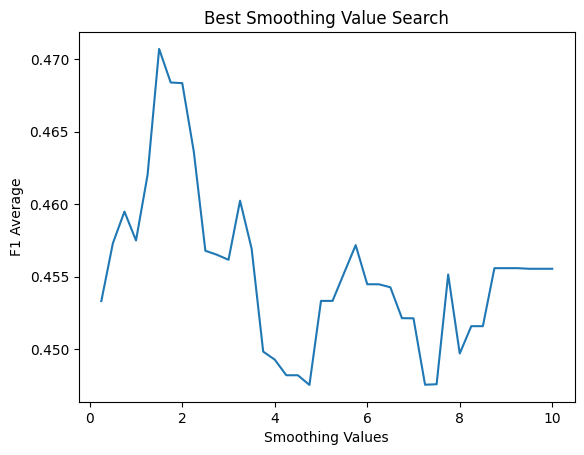

In [152]:
plt.plot(smoothing_values[1:], history[1:])
plt.xlabel("Smoothing Values")
plt.ylabel("F1 Average")
plt.title("Best Smoothing Value Search")
print(f"Best smoothing : {best_smoothing}")

### 9. Test the model with the best calculated smoothing value

In [153]:
# Go through the test data
token_probabilities = calculate_probability(best_smoothing)
predictions = [classify(data.text, token_probabilities) for _, data in test_data.iterrows()]
actual = [data.label for _, data in test_data.iterrows()]

print("PREDICTION =>", predictions)
print("ACTUAL => ",actual)
print(classification_report(actual, predictions, labels=[0,1,2]))


PREDICTION => [2, 2, 1, 1, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 0, 0, 0, 2, 1, 0, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 2, 1, 1, 0, 2, 2, 1, 2, 2, 0, 1, 0, 1, 0, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 1, 1, 1, 2, 2, 1, 0, 0, 2, 0, 2, 1, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 0, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 0, 2, 2, 1, 0, 0, 2, 0, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 0, 1, 0, 2, 2, 1, 2, 1, 0, 1, 0, 2, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2